# David Ogaus, Jonathan Caspar, Tommy Côté et Xiuli Zhang 
## IFT 3700
## 6 Novembre 2018
## Travail 1

## Mesure de similarité
ON va mettre ici notre description de la mesure de similarité

In [5]:
# La métrique euclidienne
def metric_euclid(x, y):
    sum=0
    for i in range(len(x)):
        sum += (x[i]-y[i])**2
    return math.sqrt(sum)

# La métrique #1 dans le fichier word
def metric_n1(x, y):
    sum_x=0
    sum_y=0
    for i in range(len(x)):
        sum_x += x[i]
        sum_y += y[i]
    return abs(sum_x - sum_y)

# La métrique #3 dans le fichier word
def metric_n3(x, y):
    sum=0
    for i in range(len(x)):
        if ((x[i]==0 and y[i]==0) or (x[i]!=0 and y[i]!=0)):
            sum+=1
    return 1 - sum/784

## Importation du jeu de données MNIST

In [6]:
import csv
import random
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

#On ouvre le fichier 'mnist_train.csv'
data = open('e:\ift3700\mnist_train.csv')
csv_file = csv.reader(data)
data_points = []
for row in csv_file:
    data_points.append(row)
data.close()

#On enlève la première ligne, soit les "headers" de nos colonnes
data_points.pop(0)

#On transforme les données en integers
for i in range(len(data_points)):
    for j in range(0,785):
            data_points[i][j] = int(data_points[i][j])

#Vecteur 60 000 x 1 qui contient les étiquettes
y_train = []
for row in data_points:
    y_train.append(row[0])

#Matrice 60 000 x 784 qui contient les données
x_train = []
for row in data_points:
    x_train.append(row[1:785])
    
#On ouvre le fichier 'mnist_test.csv'
data = open('e:\ift3700\mnist_test.csv')
csv_file = csv.reader(data)
data_points = []
for row in csv_file:
    data_points.append(row)
data.close()

#On enlève la première ligne, soit les "headers" de nos colones
data_points.pop(0)

#Convertir en int
for i in range(len(data_points)):
    for j in range(0,785):
            data_points[i][j] = int(data_points[i][j])

#Vecteur 10 000 x 1 qui contient les étiquettes
y_test = []
for row in data_points:
    y_test.append(row[0])

#Matrice 10 000 x 784 qui contient les données
x_test = []
for row in data_points:
    x_test.append(row[1:785])

## Algorithme k-moyenne

In [5]:
def k_medoid(distances, k=10):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)

    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point.
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    assert (clusters[medoids] == medoids).all()
    return clusters
    
def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

Text(0.5,1,'Score silhouette en fonction de k')

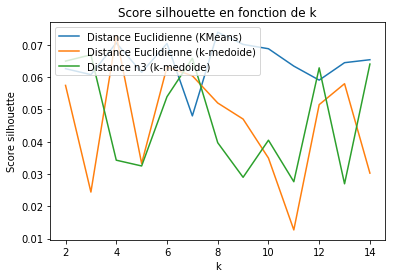

In [6]:
#Ensemble de donné réduit pour faire des tests
x__test= x_test[0:500]

# Définie une matrice des distances avec la métrique de notre choix
m_eucli = pairwise_distances(x__test, metric='euclidean')
m_n3 = pairwise_distances(x__test, metric=metric_n3)

scores = []
scores_t=[]
scores_n3=[]
k_range = range(2,15)
for k in k_range:
    y_pred = KMeans(n_clusters=k).fit_predict(x__test)
    scores.append(silhouette_score(x__test, y_pred))
    
    y_pred_t = k_medoid(m_eucli, k)
    scores_t.append(silhouette_score(x__test, y_pred_t))
    
    y_pred_n3 = k_medoid(m_n3, k)
    scores_n3.append(silhouette_score(x__test, y_pred_n3))

plt.plot(k_range, scores, label='Distance Euclidienne (KMeans)')
plt.plot(k_range, scores_t, label='Distance Euclidienne (k-medoide)')
plt.plot(k_range, scores_n3, label='Distance n3 (k-medoide)')
plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')

## KNN (Plus Proches Voisins)

0.925
1
0.875
1


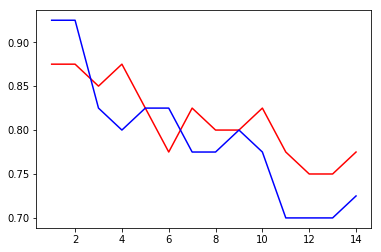

In [7]:
from sklearn import neighbors
from sklearn.model_selection import train_test_split

x__train = x_train[0:200]
y__train = y_train[0:200]

X_train, X_test, Y_train, Y_test = train_test_split(x__train, y__train, test_size=0.2, stratify=y__train, random_state=0)

score_n3 = []
score_val = []
for k in np.arange(1, 15):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, Y_train)
    score_val.append(clf.score(X_test, Y_test))  
    
    clf_n3 = neighbors.KNeighborsClassifier(n_neighbors=k, metric = metric_n3)
    clf_n3.fit(X_train, Y_train)
    score_n3.append(clf_n3.score(X_test, Y_test))
    
plt.plot(np.arange(1, 15), score_n3, color='red')
plt.plot(np.arange(1, 15), score_val, color='blue')

print(np.max(score_val))
print(np.argmax(score_val)+1)
print(np.max(score_n3))
print(np.argmax(score_n3)+1)

## Algorithme partition binaire

Text(0.5,1,'Score silhouette en fonction de k')

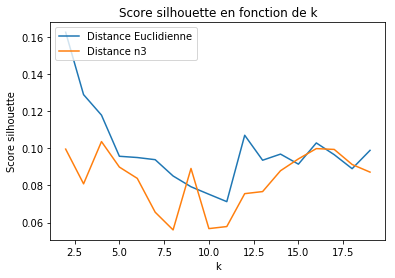

In [15]:
# Définie une matrice des distances avec la métrique de notre choix
m = pairwise_distances(x__test, metric=metric_n3)

scores = []
scores_t=[]
k_range = range(2,20)
for k in k_range:
    y_pred = AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=k).fit_predict(x__test)
    scores.append(silhouette_score(x__test, y_pred))
    y_pred_t = AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters=k).fit_predict(m)
    scores_t.append(silhouette_score(x__test, y_pred_t))
plt.plot(k_range, scores, label='Distance Euclidienne')
plt.plot(k_range, scores_t, label='Distance n3')
plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')

## Algorithme PCoA

In [ ]:
from sklearn.manifold import MDS
x__test= x_test[0:500]
m = pairwise_distances(x__test, metric=metric_n3)
#m = pairwise_distances(x__test, metric=metric_n1)
#m = pairwise_distances(x__test, metric=metric_euclid)


X_transformedEuc =MDS(n_components=1,n_init=2).fit_transform(x__test)


X_transformed =MDS(n_components=1,n_init=2,dissimilarity='precomputed').fit_transform(m)

fig1 = plt.figure()  
ax2 = fig1.add_subplot(111) 
ax2.set_title('PCoA avec notre propre Distance')
ax2.scatter(X_transformed[:,0],X_transformed[:,1] , c=y, alpha=1)
plt.show


fig = plt.figure()  
ax1 = fig.add_subplot(111) 
ax1.set_title('PCoA avec Distance Euclidienne')
ax1.scatter(X_transformedEuc[:,0],X_transformedEuc[:,1] , c=y, alpha=1)
plt.show

## Algorithme Isomap

Algorithme Isomap avec notre propre notation de similatrité et visualiser en 2D

<function matplotlib.pyplot.show(*args, **kw)>

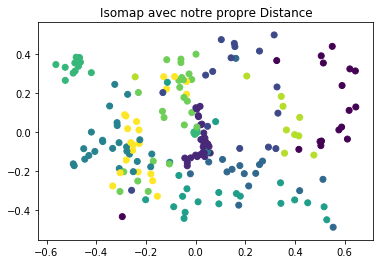

In [7]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph,KNeighborsClassifier
from sklearn.manifold import MDS
from sklearn.utils.graph import graph_shortest_path
from matplotlib.pyplot import scatter

 #isomap avec notre distance propre x:donée k:n_neighbors n:n_components
def myIsomap(x,k,n):
    kng = kneighbors_graph(x,n_neighbors=k, mode='distance',metric=metric_n3)
    #caculer le plus court chemin
    distmatrix = graph_shortest_path(kng,directed=False,method ='D')
    isomap=MDS(n_components=n,dissimilarity='precomputed')
    #isomap avec notre distance propre
    X_transformed = isomap.fit_transform(distmatrix)
    return X_transformed
x = x_test[0:200]
X_transformed = myIsomap(x,3,2) 
y=y_test[0:200]
fig1 = plt.figure()  
ax2 = fig1.add_subplot(111) 
ax2.set_title('Isomap avec notre propre Distance')
ax2.scatter(X_transformed[:,0],X_transformed[:,1] , c=y, alpha=1)
plt.show



Algorithme Isomap avec Distance Euclidienne et visualiser en 2D

<function matplotlib.pyplot.show(*args, **kw)>

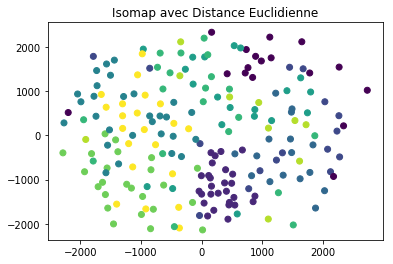

In [11]:
mds=MDS(n_components=2)
X_transformedEuc=mds.fit_transform(x)

y=y_test[0:200]
fig = plt.figure()  
ax1 = fig.add_subplot(111) 
ax1.set_title('Isomap avec Distance Euclidienne')
ax1.scatter(X_transformedEuc[:,0],X_transformedEuc[:,1] , c=y, alpha=1)
plt.show

comparer les deux figure ,la reduction dementionalité avec isomap de notre propre similarité est mieux.Car les point de même class sont plus proches que ceaux obtenus par isomap avec distance Euclidienne

 Comparer le performance  en utilisant knn classification avec différent k(nombre de voisin)et différent n (nombre de composant)

In [11]:
#préparer des donnéé
xtest = x_test[0:50]
y__test = y_test[0:50]
x__train = x_train[0:300]
y__train = y_train[0:300]
#compresser x__train avec isomap Euclidienne
for n in range(50,300,50): 
    print(n)
    mds = MDS(n_components=k)
    x__trainNew = mds.fit_transform(x__train)
    knn = KNeighborsClassifier()
    knn.fit(x__trainNew,y__train)
    x__testNew = mds.fit_transform(xtest)

   #évaluer le performance
    print("score de isomap avec distance Euclidienne:",knn.score(x__testNew,y__test))

#compresser x__train avec isomap notre distance,utiliser diffirent n
    x__MytrainNew = myIsomap(x__train,5,100)
    x__MytestNew = myIsomap(xtest,5,100)
    knn = KNeighborsClassifier()
    knn.fit(x__MytrainNew,y__train)

#évaluer le performance

    print("score de isomap avec notre distance :",knn.score(x__MytestNew,y__test))


50
score de isomap avec distance Euclidienne: 0.1
score de isomap avec notre distance : 0.12
100
score de isomap avec distance Euclidienne: 0.06
score de isomap avec notre distance : 0.24
150
score de isomap avec distance Euclidienne: 0.12
score de isomap avec notre distance : 0.04
200
score de isomap avec distance Euclidienne: 0.16
score de isomap avec notre distance : 0.08
250
score de isomap avec distance Euclidienne: 0.04
score de isomap avec notre distance : 0.28


In [10]:
#préparer des donnéé
xtest = x_test[0:50]
y__test = y_test[0:50]
x__train = x_train[0:300]
y__train = y_train[0:300]
#compresser x__train avec isomap Euclidienne
mds = MDS(n_components=300)
x__trainNew = mds.fit_transform(x__train)
knn = KNeighborsClassifier()
knn.fit(x__trainNew,y__train)
x__testNew = mds.fit_transform(xtest)

#évaluer le performance
print("score de isomap avec distance Euclidienne:",knn.score(x__testNew,y__test))

#compresser x__train avec isomap notre distance,utiliser diffirent k
for k in range(1,10):
    print("k:",k)
    x__MytrainNew = myIsomap(x__train,k,300)
    x__MytestNew = myIsomap(xtest,k,300)
    knn = KNeighborsClassifier()
    knn.fit(x__MytrainNew,y__train)

#évaluer le performance
    print("score de isomap avec notre distance :",knn.score(x__MytestNew,y__test))


score de isomap avec distance Euclidienne: 0.16
k: 1
score de isomap avec notre distance : 0.06
k: 2
score de isomap avec notre distance : 0.18
k: 3
score de isomap avec notre distance : 0.18
k: 4
score de isomap avec notre distance : 0.18
k: 5
score de isomap avec notre distance : 0.3
k: 6
score de isomap avec notre distance : 0.2
k: 7
score de isomap avec notre distance : 0.18
k: 8
score de isomap avec notre distance : 0.18
k: 9
score de isomap avec notre distance : 0.18


utiliser le donnée compressée avec isomap en utilisant deux notion de similatité ,pour classiffier avec knn,après comparer le taux de success ,notre notion de similarité n'est pas toujours mieux que distance Euclidienne ,ça depend aussi les hyperparamètres,mais la plupart de temps notre notion de similarité est meilleure que distance Euclidienne .

Comparer le performance  en utilisant cross_validation

In [13]:
from sklearn.model_selection import cross_val_score

x = x_test[0:1000]

#compresser x__train avec isomap Euclidienne
mds = MDS(n_components=300)
x__trainNew = mds.fit_transform(x__train)
knn = KNeighborsClassifier()
knn.fit(x__trainNew,y__train)
x__testNew = mds.fit_transform(xtest)
#evaluer le performance
scoresMds = cross_val_score(knn, x__trainNew,y__train, cv=5,scoring='accuracy')
print("score moyenne de isomap avec Euclidienne::",scoresMds.mean())

#compresser x__train avec isomap notre distance
x__MytrainNew = myIsomap(x__train,k,300)
x__MytestNew = myIsomap(xtest,k,300)
knn = KNeighborsClassifier()
knn.fit(x__MytrainNew,y__train)
scoresMyIsomap = cross_val_score(knn, x__MytrainNew,y__train, cv=5,scoring='accuracy')
print("score moyenne de isomap avec notre propre distance::",scoresMyIsomap.mean())

score moyenne de isomap avec Euclidienne:: 0.7780522643270416
score moyenne de isomap avec notre propre distance:: 0.8117156489772315


voila seulons cross-validation notre notion est mieux.

comparer un utilisant silhouette score

In [ ]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph,KNeighborsClassifier
from sklearn.manifold import MDS
from sklearn.utils.graph import graph_shortest_path

x = x_test[0:100]
scores = []
scores_t=[]
k_range = range(2,20,3)

for k in k_range:
    
    X_transformed = myIsomap(x,k,300)
    
    #isomp avec euclidean
    mds=MDS(n_components=300)
    X_transformedEuc=mds.fit_transform(x)
    
    
    y_pred = KMeans(n_clusters=5).fit_predict( X_transformed )
    scores.append(silhouette_score(x, y_pred))
    
    y_pred_t = KMeans(n_clusters=5).fit_predict(X_transformedEuc )
    scores_t.append(silhouette_score(x, y_pred_t))
    


plt.plot(k_range, scores, label='Distance propre (isomap)')
plt.plot(k_range, scores_t, label='Distance Euclidienne (isomap')

plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')